# 7.1 투표 기반 분류기
- 각 분류기의 예측을 모아서 가장 많이 선택된 클래스로 예측을 결정
- 약한 학습기여도 많고 다양하면 앙상블의 결과는 강한 학습기가 될 수 있음

In [1]:
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)
    
heads_proba = 0.51
coin_tosses = (np.random.rand(10000,10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1,10001).reshape(-1,1)

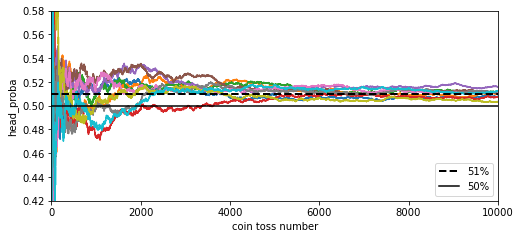

In [2]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0,10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0,10000], [0.5,0.5], "k-", label="50%")
plt.xlabel("coin toss number")
plt.ylabel("head_proba")
plt.legend(loc="lower right")
plt.axis([0,10000,0.42,0.58])
plt.show()

- 잘못된 클래스로 예측한 예측기가 많을 경우 앙상블의 정확도가 낮아진다
- 앙상블은 예측기가 가능한 한 독립적일떄 최고의 성능을 가짐

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard")
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


## 간접 투표
- 모든 분류기가 클래스의 확률을 예측할 수 있을 경우(predict_proba가 있으면) 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측할 수 있음
- voting="soft", SVC에서 probability=True

In [6]:
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# 7.2 배깅과 페이스팅
- 훈련세트의 서브셋을 샘플링할때 중복을 허용하면 배깅(복원추출) >> 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러번 샘플링 가능
- 중복을 허용하지 않으면 페이스팅(비복원추출)
- 분류일떄는 통계적 최빈값, 회귀일땐 평균을 계산   
## 7.2.1 사이킷런의 배깅과 페이스팅

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test,y_pred_tree))

0.856


In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5,-1,1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
    plt.contourf(x1,x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:,0][y==0], X[:,1][y==0], "yo", alpha=alpha)
    plt.plot(X[:,0][y==1], X[:,1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


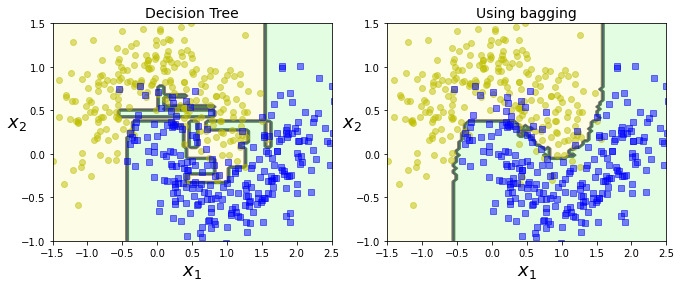

In [16]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X,y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X,y)
plt.title("Using bagging", fontsize=14)
plt.show()

## 7.2.2 oob 평가 

In [17]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500,
                            bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.8986666666666666

In [18]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [19]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# 7.4 랜덤포레스트
- 배깅(또는 페이스팅)을 적용한 결정트리의 앙상블
- DecisionTreeClassifier의 매개변수와 BaggingClassifier의 매개변수 모두 보유

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)


sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [21]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [22]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])



RandomForestClassifier(n_estimators=10, random_state=42)

In [24]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=matplotlib.cm.hot, interpolation="nearest")
    plt.axis("off")

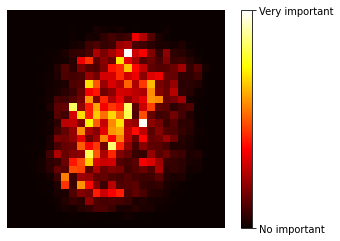

In [25]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["No important", "Very important"])

plt.show()